#### Intro: this is the notebook I use on the Databricks to analyse the yelp dataset.

In [ ]:
#import packages
import pyspark.sql.functions as f
from pyspark.sql.window import Window

### Dataset preperation

Set ADLS configurations

In [ ]:
spark.conf.set("fs.azure.account.key.yelpprojectlbw.dfs.core.windows.net", "< my account key>)")

List datasets in ADLS

In [ ]:
dbutils.fs.ls("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/")

[FileInfo(path='abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_delta/', name='json_to_delta/', size=0, modificationTime=1709644159000),
 FileInfo(path='abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_parquet/', name='json_to_parquet/', size=0, modificationTime=1709643524000),
 FileInfo(path='abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/yelp_academic_dataset_business.json', name='yelp_academic_dataset_business.json', size=118863795, modificationTime=1709642676000),
 FileInfo(path='abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/yelp_academic_dataset_checkin.json', name='yelp_academic_dataset_checkin.json', size=286958945, modificationTime=1709642674000),
 FileInfo(path='abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/yelp_academic_dataset_review.json', name='yelp_academic_dataset_review.json', size=5341868833, modificationTime=1709642700000),
 FileInfo(path='abfss://yelp-target-

Read yelp datasets in ADLS and convert JSON to parquet for better performance

In [ ]:
df_business = spark.read.json("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/yelp_academic_dataset_business.json")
df_business.write.mode('overwrite').parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_parquet/business.parquet")

df_checkin = spark.read.json("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/yelp_academic_dataset_checkin.json")
df_checkin.write.mode('overwrite').parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_parquet/checkin.parquet")

df_review = spark.read.json("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/yelp_academic_dataset_review.json")
df_review.write.mode('overwrite').parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_parquet/review.parquet")

df_tip = spark.read.json("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/yelp_academic_dataset_tip.json")
df_tip.write.mode('overwrite').parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_parquet/tip.parquet")

df_user = spark.read.json("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/yelp_academic_dataset_user.json")
df_user.write.mode('overwrite').parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_parquet/user.parquet")

Convert JSON to Delta Format (but in this project we use parquet)

In [ ]:
df_business.write.mode('overwrite').parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_delta/business.delta")

Read parquet file

In [ ]:
df_business = spark.read.parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_parquet/business.parquet")
df_checkin = spark.read.parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_parquet/checkin.parquet")
df_review = spark.read.parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_parquet/review.parquet")
df_tip = spark.read.parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_parquet/tip.parquet")
df_user = spark.read.parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/json_to_parquet/user.parquet")

Total records in each datasets

In [ ]:
print("df_tip: " + str(df_tip.count()))
print("df_checkin: " + str(df_checkin.count()))
print("df_business: " + str(df_business.count()))
print("df_review: " + str(df_review.count()))
print("df_user: " + str(df_user.count()))   

df_tip: 908915
df_checkin: 131930
df_business: 150346
df_review: 6990280
df_user: 1987897


In [ ]:
df_tip.count()

908915

### Partition the dataset

Extract `year` and `month` from `date` column for `tip` dataset, we add two columns: `tip_year` and `tip_month`.

In [ ]:
df_tip = df_tip.withColumn("tip_year", f.year(f.to_date(f.col("date"))))
df_tip = df_tip.withColumn("tip_month", f.month(f.to_date(f.col("date"))))

Partition dataset tip by year and month

In [ ]:
df_tip.write.mode("overwrite").partitionBy("tip_year", "tip_month").parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/tip_partitioned_by_year_and_month/")

`repartition()` vs `coalesce()`

In [ ]:
#  Difference between coalesce and repartition
#  
#  coalesce uses existing partitions to minimize the amount of data that's shuffled. repartition creates new partitions and does a full shuffle. coalesce results in partitions with different amounts of data (sometimes partitions that have much different sizes) and repartition results in roughly equal sized partitions.
#  
#  Is coalesce or repartition faster?
#  
#  coalesce may run faster than repartition, but unequal sized partitions are generally slower to work with than equal sized partitions. You'll usually need to repartition datasets after filtering a large data set. I've found repartition to be faster overall because Spark is built to work with equal sized partitions.

In [ ]:
print("current number of partitions: " + str(df_user.rdd.getNumPartitions()))

# reduce the number of partitions to 10, with coalesce we can not increase number of partitions
df_reduce_part = df_user.coalesce(10)
print("reduced number of partitions after coalesce: " + str(df_reduce_part.rdd.getNumPartitions()))

# repartition the data
df_increased_df = df_user.repartition(30)
print("increased number of partitions after coalesce: " + str(df_increased_df.rdd.getNumPartitions()))

current number of partitions: 25
reduced number of partitions after coalesce: 10
increased number of partitions after coalesce: 30


In [ ]:
# coalesce takes less time than repartition
df_user.coalesce(10).write.mode('overwrite').parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/coalesce/user.parquet")

In [ ]:
# repartition
df_user.repartition(10).write.mode('overwrite').parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/repartition/user.parquet")

### Dataset analysis

##### Analyses `user` dataset

In [ ]:
# use the repartitioned data
df_user = spark.read.parquet("abfss://yelp-target-container@yelpprojectlbw.dfs.core.windows.net/repartition/user.parquet")

In [ ]:
# Create or replace a temporary view using a DataFrame for subsequent Spark SQL queries and analysis. Once the SparkSession is closed, the temporary view will also be removed.
df_user.createOrReplaceTempView("user")

Find the top 3 users based on their total number of reviews

In [ ]:
%sql
select
  user_id,
  name,
  review_count
from
  user
order by
  review_count desc
limit
  3;

user_id,name,review_count
Hi10sGSZNxQH3NLyWSZ1oA,Fox,17473
8k3aO-mPeyhbR5HUucA5aA,Victor,16978
hWDybu_KvYLSdEFzGrniTw,Bruce,16567


Find the top 10 users with the most fans

In [ ]:
%sql
select user_id, name, fans
from user
order by fans desc
limit 10;

user_id,name,fans
37cpUoM8hlkSQfReIEBd-Q,Mike,12497
hizGc5W1tBHPghM5YKCAtg,Katie,3642
Hi10sGSZNxQH3NLyWSZ1oA,Fox,3493
JjXuiru1_ONzDkYVrHN0aw,Richard,3243
j14WgRoU_-2ZE1aw1dXrJg,Daniel,3138
VHdY6oG2JPVNjihWhOooAQ,Jessica,2627
iLjMdZi0Tm7DQxX1C1_2dg,Ruggy,2547
lt7bNHl-TXziny4FETu8nA,Megan,2451
fgwI3rYHOv1ipfVfCSx7pg,Emi,2424
ITa3vh5ERI90G_WP4SmGUQ,Peter,2388


##### Analyses `business` dataset

Analyse top 10 categories by number of reviews

In [ ]:
df_business_cat= df_business.groupBy("categories").agg(f.count("review_count").alias("total_review_count"))
df_top_categories = df_business_cat.withColumn("rnk", f.row_number().over(Window.orderBy(f.col('total_review_count').desc())))
df_top_categories = df_top_categories.filter(f.col('rnk') <= 10)
display(df_top_categories)

categories,total_review_count,rnk
"Beauty & Spas, Nail Salons",1012,1
"Restaurants, Pizza",935,2
"Nail Salons, Beauty & Spas",934,3
"Pizza, Restaurants",823,4
"Restaurants, Mexican",728,5
"Restaurants, Chinese",708,6
"Mexican, Restaurants",672,7
"Chinese, Restaurants",651,8
"Food, Coffee & Tea",508,9
"Beauty & Spas, Hair Salons",493,10


In [1]:
!pip install pip install ipython

  Obtaining dependency information for install from https://files.pythonhosted.org/packages/4d/c8/8cbca135f9e167810756ea2bc34b028501936675fcbd7dadccf752fa4622/install-1.3.5-py3-none-any.whl.metadata


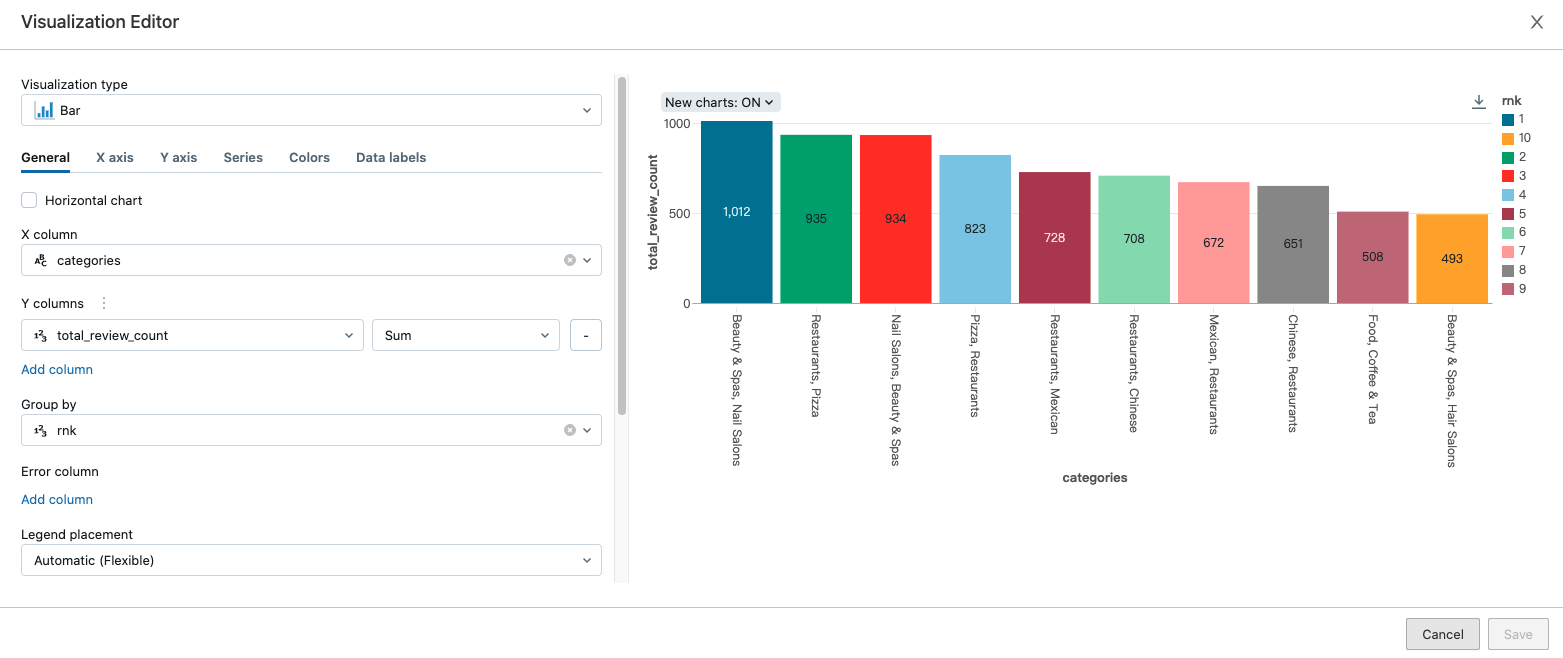

In [1]:
from IPython.display import Image

Image(filename='./image-1/visualization.png')


We can also perform this using SQL

In [ ]:
df_business.createOrReplaceTempView("business")

In [ ]:
%sql
SELECT categories, total_review_count FROM (
    SELECT business_categories.*, 
    ROW_NUMBER() OVER (ORDER BY total_review_count DESC) AS rn 
    FROM (SELECT categories, count(review_count) AS total_review_count FROM business GROUP BY categories) business_categories
)
WHERE rn <= 10;

categories,total_review_count
"Beauty & Spas, Nail Salons",1012
"Restaurants, Pizza",935
"Nail Salons, Beauty & Spas",934
"Pizza, Restaurants",823
"Restaurants, Mexican",728
"Restaurants, Chinese",708
"Mexican, Restaurants",672
"Chinese, Restaurants",651
"Food, Coffee & Tea",508
"Beauty & Spas, Hair Salons",493


Databricks visualization. Run in Databricks to view.

Using CTE improves code readability.

In [ ]:
%sql
WITH business_categories AS (
    SELECT categories, COUNT(review_count) AS total_review_count
    FROM df_business
    GROUP BY categories
),
top_categories AS (
    SELECT categories, total_review_count,
           ROW_NUMBER() OVER (ORDER BY total_review_count DESC) AS rnk
    FROM business_categories
)
SELECT categories, total_review_count
FROM top_categories
WHERE rnk <= 10;

ROW_NUMBER() is a window function in SQL, used to assign a unique sequential number to each row in a query result set. 
It is typically used to sort rows in the result set and assign a ranking or sequence number to each row.

Analyse top business which have over 1000 reviews

In [ ]:
df_business_reviews = df_business.groupBy("categories").agg(f.count("review_count").alias("total_review_count"))
df_top_business = df_business_reviews.filter(df_business_reviews["total_review_count"] >= 1000).orderBy(f.desc("total_review_count"))

In [ ]:
display(df_top_business)

categories,total_review_count
"Beauty & Spas, Nail Salons",1012


SQL version

In [ ]:
%sql
SELECT categories, COUNT(review_count) AS total_review_count
FROM df_business
GROUP BY categories
HAVING COUNT(review_count) >= 1000
ORDER BY total_review_count DESC;

Analyse Business Data: Number of restaurants per state

In [ ]:
df_num_of_restaurants = df_business.select('state').groupBy('state').count().orderBy(f.desc("count"))
display(df_num_of_restaurants)

state,count
PA,34039
FL,26330
TN,12056
IN,11247
MO,10913
LA,9924
AZ,9912
NJ,8536
NV,7715
AB,5573


SQL version

In [ ]:
%sql
SELECT state, COUNT(*) AS count
FROM df_business
GROUP BY state
ORDER BY count DESC;

Analyse top 3 restaurants in each state

In [ ]:
df_business.createOrReplaceTempView("business_restaurant")

In [ ]:
%sql
SELECT * FROM (
    SELECT STATE,name,review_count,
    ROW_NUMBER() OVER ( PARTITION BY STATE ORDER BY review_count DESC) rn 
    FROM business_restaurant
)
WHERE rn <= 3

STATE,name,review_count,rn
AB,Duchess Bake Shop,486,1
AB,SugarBowl,435,2
AB,Tres Carnales Taqueria,429,3
AZ,Prep & Pastry,2126,1
AZ,El Charro Cafe,1583,2
AZ,Cafe Poca Cosa,1306,3
CA,Los Agaves,3834,1
CA,Brophy Bros - Santa Barbara,2940,2
CA,Boathouse at Hendry's Beach,2536,3
CO,Two Elk Restaurant,12,1


List the top restaurants in a state by the number of reviews

In [ ]:
df_business_Arizona = df_business.filter(df_business['state']=='AZ')
df_Arizona = df_business_Arizona.groupBy("name").agg(f.count("review_count").alias("total_review_count"))
window = Window.orderBy(df_Arizona['total_review_count'].desc())
df_Arizona_best_rest = df_Arizona.select('*', f.rank().over(window).alias('rank')).filter(f.col('rank') <= 10)
display(df_Arizona_best_rest)

name,total_review_count,rank
Starbucks,63,1
Subway,50,2
Walgreens,44,3
McDonald's,41,4
eegee's,27,5
The UPS Store,26,6
Circle K,24,7
Burger King,23,8
Taco Bell,22,9
Supercuts,21,10


SQL version

In [ ]:
%sql
WITH Arizona_business AS (
    SELECT name, COUNT(review_count) AS total_review_count
    FROM df_business
    WHERE state = 'AZ'
    GROUP BY name
),
Ranked_Arizona_business AS (
    SELECT name, total_review_count,
           RANK() OVER (ORDER BY total_review_count DESC) AS rank
    FROM Arizona_business
)
SELECT *
FROM Ranked_Arizona_business
WHERE rank <= 10;

Numbers of restruans in Arizona state per city

In [ ]:
df_business_Arizona = df_business.filter(df_business['state']=='AZ')
df_business_Arizona = df_business_Arizona.groupBy('city').count().orderBy(f.desc("count"))

In [ ]:
#Visualise number of restaurants in Arizona City, city Phoneix can be visualised from here that is having maximum number of restaurants
display(df_business_Arizona)

city,count
Tucson,9249
Oro Valley,286
Marana,102
Green Valley,69
Sahuarita,69
Vail,51
Tuscon,18
Catalina,13
Mount Lemmon,7
TUCSON,6


SQL version

In [ ]:
%sql
SELECT city, COUNT(*) AS count
FROM df_business
WHERE state = 'AZ'
GROUP BY city
ORDER BY count DESC;

Select City with highest number of restaurants

In [ ]:
window = Window.orderBy(df_business_Arizona['count'].desc())
city_with_max_rest = df_business_Arizona \
                    .select('*', f.rank().over(window).alias('rank')).filter(f.col('rank') <= 1) \
                    .drop('rank')
display(city_with_max_rest)

city,count
Tucson,9249


SQL version

In [ ]:
%sql
WITH Ranked_city_with_max_rest AS (
    SELECT *, RANK() OVER (ORDER BY count DESC) AS rank
    FROM (
        SELECT city, COUNT(*) AS count
        FROM df_business
        WHERE state = 'AZ'
        GROUP BY city
    ) AS city_counts
)
SELECT city, count
FROM Ranked_city_with_max_rest
WHERE rank <= 1;

We don't use 'LIMIT' here because 'LIMIT' cannot handle cases with the same values well.

Broadcast join

In [ ]:
from pyspark.sql.functions import broadcast

# Join arizona city dataset with business datasets to get more details
df_best_restaurants = df_business.join(broadcast(city_with_max_rest),"city", 'inner')
df_best_restaurants = df_best_restaurants.groupBy("name","stars").agg(f.count("review_count").alias("review_count"))
df_best_restaurants = df_best_restaurants.filter(df_best_restaurants["review_count"] >= 10)
df_best_restaurants = df_best_restaurants.filter(df_best_restaurants["stars"] >= 3)

Broadcast Join is an optimization technique used to improve the performance of join operations when dealing with large datasets.

In [ ]:
#Visualize restaurants as per review ratings in Pheonix city
display(df_best_restaurants)

name,stars,review_count
Starbucks,3.5,15
eegee's,3.5,12
eegee's,3.0,10
Walgreens,3.0,10
Subway,3.5,12
Subway,3.0,13
Starbucks,3.0,13
Starbucks,4.0,13


SQL version

In [ ]:
%sql
WITH Best_Restaurants AS (
    SELECT b.name, b.stars, COUNT(b.review_count) AS review_count
    FROM df_business b
    JOIN city_with_max_rest c ON b.city = c.city
    GROUP BY b.name, b.stars
)
SELECT *
FROM Best_Restaurants
WHERE review_count >= 10 AND stars >= 3;

Most rated Italian restaurant in Pheonix

In [ ]:
df_business_Pheonix = df_business.filter(df_business.city == 'Phoenix')
df_business_italian = df_business_Pheonix.filter(df_business.categories.contains('Italian'))
df_best_italian_restaurants = df_business_italian.groupBy("name").agg(f.count("review_count").alias("review_count"))

df_best_italian_restaurants = df_best_italian_restaurants.filter(df_best_italian_restaurants["review_count"] >= 5)
display(df_best_italian_restaurants)

name,review_count


In [ ]:
display(df_best_italian_restaurants)

name,review_count


SQL version

In [ ]:
%sql
WITH Italian_Restaurants AS (
    SELECT name, COUNT(review_count) AS review_count
    FROM df_business
    WHERE city = 'Phoenix' AND categories LIKE '%Italian%'
    GROUP BY name
)
SELECT *
FROM Italian_Restaurants
WHERE review_count >= 5;